<a href="https://colab.research.google.com/github/xxFirefly/mpc_rl_capsubot/blob/f%2Fadd-colab/example_mpc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Example of model usage

In [15]:
#%matplotlib
if 'google.colab' in str(get_ipython()):
  import os
  if (os.path.split(os.getcwd())[-1] != 'mpc_rl_capsubot'):
    import os
    !git clone https://github.com/xxFirefly/mpc_rl_capsubot  
    !pip install casadi==3.5.5
    os.chdir("mpc_rl_capsubot")
  !git pull

from envs.CapsubotEnv import CapsubotEnv
import numpy as np
from time import time
import matplotlib.pyplot as plt
import scipy.constants

# https://github.com/MMehrez/MPC-and-MHE-implementation-in-MATLAB-using-Casadi/blob/master/workshop_github/Python_Implementation/mpc_code.py

# pip install casadi
from casadi import *

try:
    env.close()
except Exception:
    pass

env = CapsubotEnv()

Already up to date.


/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


# Helper functions

In [16]:
def shift_timestep(step_horizon, t0, state_init, u, f):
    f_value = f(state_init, u[:, 0])
    next_state = DM.full(state_init + (step_horizon * f_value))

    t0 = t0 + step_horizon
    u0 = horzcat(
        u[:, 1:],
        reshape(u[:, -1], -1, 1)
    )

    return t0, next_state, u0


def DM2Arr(dm):
    return np.array(dm.full())

# State and control variables.

In [17]:
# Based on the exapmle 
# https://github.com/MMehrez/MPC-and-MHE-implementation-in-MATLAB-using-Casadi/blob/master/workshop_github/Python_Implementation/mpc_code.py

x = SX.sym("x")
xi = SX.sym("xi")
x_dot = SX.sym("x_dot")
xi_dot = SX.sym("xi_dot")
states = vertcat(x, x_dot, xi, xi_dot)
n_states = states.numel()
force = SX.sym("F")
controls = vertcat(force)
n_controls = controls.numel()


# MPC and optimal control parameters.

---



In [18]:
# Setting matrix_weights' variables. For objective function??
Q_x = 100
Q_x_dot = 1
Q_xi = 50
Q_xi_dot = 1
R_1 = 1

step_horizon = 0.01 # Time between steps in seconds.
N = 10 #int(0.1 / env.dt)  # Prediction horizon.
sim_time = 100

F_max = 1.25 # Need to add proper force model
F_min = 0 

# Initial and target values.
x_init = 0
x_dot_init = 0
xi_init = 0
xi_dot_init = 0
x_target = 0.2
x_dot_target = 0
xi_target = 0
xi_dot_target = 0



# A vector that represents the states over the optimization problem.
X = SX.sym("X", n_states, (N + 1))
# Decision variables (controls)
U = SX.sym("U", n_controls, N)
# Parameters (which include the initial state and the reference state)
P = SX.sym("P", n_states + n_states)
# state weights matrix (Q_X, Q_Y, Q_THETA)
Q = diagcat(Q_x, Q_x_dot, Q_xi, Q_xi_dot)
# controls weights matrix
R = diagcat(R_1)

# Model

In [19]:
friction = env.friction_model(x_dot)
x_acc = (env.stiffness * xi - force + friction) / env.M
xi_acc = (-env.stiffness * xi + force) / env.m - x_acc

rhs = vertcat(x_dot, x_acc, xi_dot, xi_acc)  # System r.h.s

# Nonlinear mapping function f(x,u).
f = Function("f", [states, controls], [rhs])

In [20]:
cost_fn = 0 # Cost function.
g = X[:, 0] - P[:n_states] # Constraints in the equation. 

In [21]:
# Runge kutta.
for k in range(N):
    st = X[:, k]
    con = U[:, k]
    cost_fn = cost_fn \
        + (st - P[n_states:]).T @ Q @ (st - P[n_states:]) \
        + con.T @ R @ con
    st_next = X[:, k+1]
    k1 = f(st, con)
    k2 = f(st + step_horizon/2*k1, con)
    k3 = f(st + step_horizon/2*k2, con)
    k4 = f(st + step_horizon * k3, con)
    st_next_RK4 = st + (step_horizon / 6) * (k1 + 2 * k2 + 2 * k3 + k4)
    g = vertcat(g, st_next - st_next_RK4)

# Problem solving

In [22]:
OPT_variables = vertcat(
    X.reshape((-1, 1)), U.reshape((-1, 1))  # Example: 3x11 ---> 33x1 where 3=states, 11=N+1
)
nlp_prob = {"f": cost_fn, "x": OPT_variables, "g": g, "p": P}

opts = {
    "ipopt": {
        "max_iter": 2000,
        "print_level": 0,
        "acceptable_tol": 1e-8,
        "acceptable_obj_change_tol": 1e-6,
    },
    "print_time": 0,
}

solver = nlpsol("solver", "ipopt", nlp_prob, opts)

lbx = DM.zeros((n_states * (N + 1) + n_controls * N, 1))
ubx = DM.zeros((n_states * (N + 1) + n_controls * N, 1))

lbx[0 : n_states * (N + 1) : n_states] = -inf  # X lower bound
lbx[1 : n_states * (N + 1) : n_states] = -inf  # x_dot lower bound
lbx[2 : n_states * (N + 1) : n_states] = -inf  # xi lower bound
lbx[3 : n_states * (N + 1) : n_states] = -inf  # xi_dot lower bound


ubx[0 : n_states * (N + 1) : n_states] = inf  # X lower bound
ubx[1 : n_states * (N + 1) : n_states] = inf  # x_dot upper bound
ubx[2 : n_states * (N + 1) : n_states] = inf  # xi lower bound
ubx[3 : n_states * (N + 1) : n_states] = inf  # xi_dot upper bound


lbx[n_states * (N + 1) :] = F_min  # v lower bound for F.
ubx[n_states * (N + 1) :] = F_max  # v upper bound for F


args = {
    "lbg": DM.zeros((n_states * (N + 1), 1)),  # constraints lower bound
    "ubg": DM.zeros((n_states * (N + 1), 1)),  # constraints upper bound
    "lbx": lbx,
    "ubx": ubx,
}

In [23]:
t0 = 0
state_init = DM([x_init, x_dot_init, xi_init, xi_dot_init])  # initial state
state_target = DM([x_target, x_dot_target, xi_target, xi_dot_target])  # target state

t = DM(t0)

u0 = DM.zeros((n_controls, N))  # initial control
X0 = repmat(state_init, 1, N + 1)  # initial state full


mpc_iter = 0
cat_states = DM2Arr(X0)
cat_controls = DM2Arr(u0[:, 0])
times = np.array([[0]])
main_loop = time()  # return time in sec
age = 0
while (norm_2(state_init - state_target) > 1e-1) and (mpc_iter * step_horizon < sim_time):
    age += 1
    if (age == 100):
      break
    t1 = time()
    args["p"] = vertcat(state_init, state_target)  # current state  # target state
    # optimization variable current state
    args["x0"] = vertcat(reshape(X0, n_states * (N + 1), 1), reshape(u0, n_controls * N, 1))


    sol = solver(
        x0=args["x0"],
        lbx=args["lbx"],
        ubx=args["ubx"],
        lbg=args["lbg"],
        ubg=args["ubg"],
        p=args["p"],
    )

    u = reshape(sol["x"][n_states * (N + 1) :], n_controls, N)
    X0 = reshape(sol["x"][: n_states * (N + 1)], n_states, N + 1)

    cat_states = np.dstack((cat_states, DM2Arr(X0)))

    cat_controls = np.vstack((cat_controls, DM2Arr(u[:, 0])))
    t = np.vstack((t, t0))

    t0, state_init, u0 = shift_timestep(step_horizon, t0, state_init, u, f)

    X0 = horzcat(X0[:, 1:], reshape(X0[:, -1], -1, 1))
    x = float(X0[0,0])
    x_dot = float(X0[1,0])
    print("x:{:.5f}, x_dot:{:.5f} u:{:.2f}".format(x, x_dot, float(u0[0])))

    t2 = time()
    times = np.vstack((times, t2 - t1))
    mpc_iter = mpc_iter + 1

main_loop_time = time()
ss_error = norm_2(state_init - state_target)

print("\n\n")
print("Total time: ", main_loop_time - main_loop)
print("avg iteration time: ", np.array(times).mean() * 1000, "ms")
print("final error: ", ss_error)

x:-0.00000, x_dot:0.02021 u:0.00
x:0.00021, x_dot:-0.00140 u:0.01
x:0.00063, x_dot:0.03805 u:0.00
x:0.00145, x_dot:-0.01694 u:0.00
x:0.00172, x_dot:0.01051 u:0.00
x:0.00226, x_dot:-0.04965 u:0.00
x:0.00220, x_dot:-0.01407 u:0.00
x:0.00249, x_dot:-0.01031 u:0.00
x:0.00241, x_dot:0.01903 u:0.30
x:0.00304, x_dot:0.01944 u:0.13
x:0.00366, x_dot:0.06417 u:0.10
x:0.00431, x_dot:0.00848 u:0.10
x:0.00480, x_dot:-0.04224 u:0.08
x:0.00481, x_dot:-0.04340 u:0.01
x:0.00528, x_dot:-0.03078 u:0.00
x:0.00499, x_dot:-0.03043 u:0.00
x:0.00425, x_dot:-0.05765 u:0.00
x:0.00324, x_dot:-0.07905 u:0.00
x:0.00245, x_dot:0.06678 u:0.00
x:0.00223, x_dot:0.12255 u:0.12
x:0.00343, x_dot:0.17993 u:0.37
x:0.00514, x_dot:0.20969 u:0.55
x:0.00717, x_dot:0.14209 u:0.51
x:0.00857, x_dot:-0.02877 u:0.25
x:0.00883, x_dot:-0.21060 u:0.00
x:0.00504, x_dot:-0.61598 u:0.00
x:-0.00112, x_dot:-0.79309 u:0.00
x:-0.00905, x_dot:-0.81610 u:0.00
x:-0.01722, x_dot:-0.55319 u:0.00
x:-0.02275, x_dot:0.00841 u:0.77
x:-0.02329, x_dot:

No handles with labels found to put in legend.


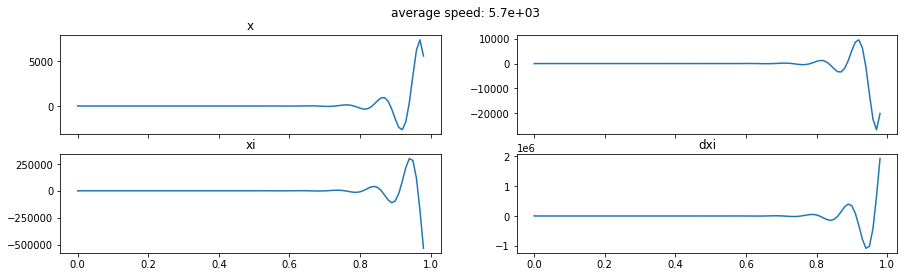

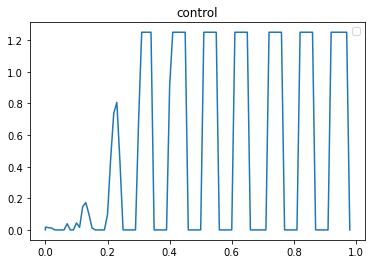

In [24]:
fig, axs = plt.subplots(2, 2, sharex=True)  # , sharex=True, sharey=True)
fig.set_figwidth(15)
fig.suptitle("average speed: {:.3}".format(cat_states[0, 1, -1] / t[-1, 0]))
axs[0, 0].plot(t, cat_states[0, 1, :], label="x")
axs[0, 0].set_title("x")
axs[1, 0].plot(t, cat_states[1, 1, :], label="dx")
axs[1, 0].set_title("dx")
axs[0, 1].plot(t, cat_states[2, 1, :], label="xi")
axs[1, 0].set_title("xi")
axs[1, 1].plot(t, cat_states[3, 1, :], label="dxi")
axs[1, 1].set_title("dxi")
# t_shift = 3
# axs[0, 0].set_xlim(t_shift, t_shift + 1)


plt.figure()
plt.title("control")
plt.plot(t, cat_controls[:, 0])
plt.legend()
plt.show()



In [25]:
cat_controls.shape

(100, 1)

In [26]:
cat_controls[:, 0]

array([0.00000000e+00, 1.75723401e-02, 1.42960869e-02, 1.19031559e-02,
       9.43797592e-08, 8.56082839e-09, 0.00000000e+00, 0.00000000e+00,
       3.91169521e-02, 0.00000000e+00, 4.96392387e-09, 4.41598054e-02,
       1.63765613e-02, 1.47390128e-01, 1.72475325e-01, 1.00192792e-01,
       1.30998195e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 9.84662774e-02, 4.47072581e-01, 7.37477614e-01,
       8.06116974e-01, 4.30837274e-01, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 6.87711093e-01,
       1.25000000e+00, 1.25000000e+00, 1.25000000e+00, 1.25000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 9.09755318e-01, 1.25000000e+00, 1.25000000e+00,
       1.25000000e+00, 1.25000000e+00, 1.25000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.25000000e+00, 1.25000000e+00, 1.25000000e+00, 1.25000000e+00,
      

In [27]:
cat_controls[:, :]

array([[0.00000000e+00],
       [1.75723401e-02],
       [1.42960869e-02],
       [1.19031559e-02],
       [9.43797592e-08],
       [8.56082839e-09],
       [0.00000000e+00],
       [0.00000000e+00],
       [3.91169521e-02],
       [0.00000000e+00],
       [4.96392387e-09],
       [4.41598054e-02],
       [1.63765613e-02],
       [1.47390128e-01],
       [1.72475325e-01],
       [1.00192792e-01],
       [1.30998195e-02],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [9.84662774e-02],
       [4.47072581e-01],
       [7.37477614e-01],
       [8.06116974e-01],
       [4.30837274e-01],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [6.87711093e-01],
       [1.25000000e+00],
       [1.25000000e+00],
       [1.25000000e+00],
       [1.25000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
